Successfully loaded the dataset.


C:\Users\ACER\AppData\Local\Temp\ipykernel_28864\4110345250.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Customer ID'] = df['Customer ID'].astype(int)



Data after initial cleaning:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom        83.4  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  
3 2009-12-01 07:45:00   2.10        13085  United Kingdom       100.8  
4 2009-12-01 07:45:00   1.25        13085  United Kingdom        30.0  

Our dataset now has 805549 rows and 9 columns.
Snapshot date for analysis: 2011-12-10 12:50:00

RFM Data for each cu

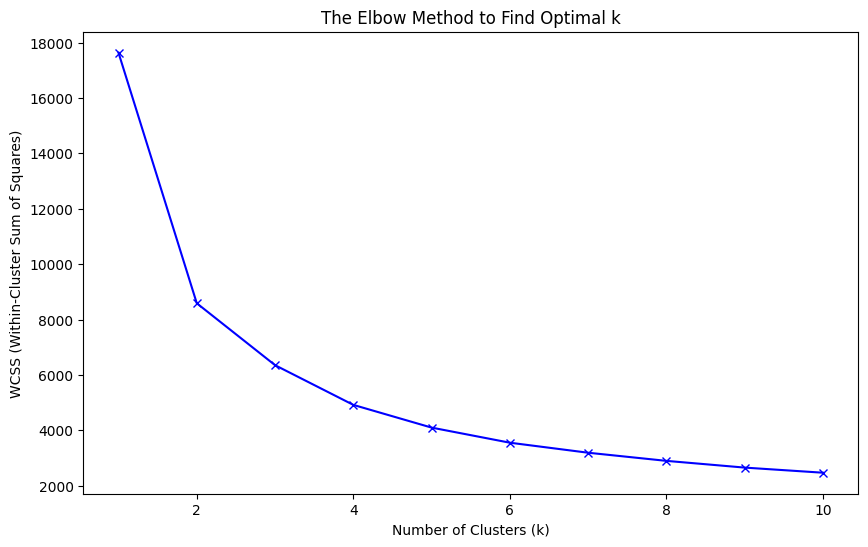


Analysis of Customer Segments:
         Recency  Frequency  MonetaryValue
Cluster                                   
0         394.66       1.41         344.06
1          25.51      19.89       11386.98
2          28.51       3.01         856.19
3         213.50       5.39        2139.52

RFM Data with Segment Names:
             Recency  Frequency  MonetaryValue  Cluster              Segment
Customer ID                                                                 
12346            326         12       77556.46        1            Champions
12347              2          8        5633.32        1            Champions
12348             75          5        2019.40        3  Potential Loyalists
12349             19          4        4428.69        2        New Customers
12350            310          1         334.40        0              At-Risk

--- Churn Prediction Model Evaluation ---
Model Accuracy: 1.00

Confusion Matrix:


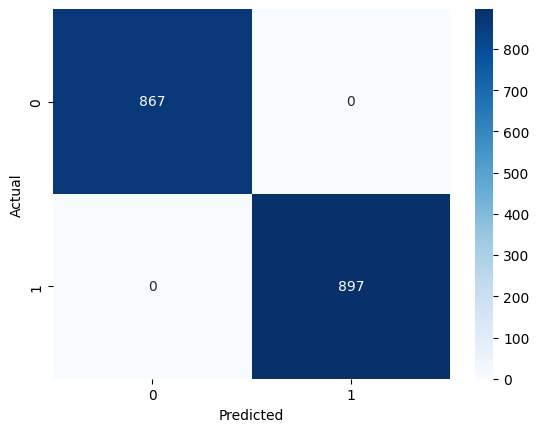


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       867
           1       1.00      1.00      1.00       897

    accuracy                           1.00      1764
   macro avg       1.00      1.00      1.00      1764
weighted avg       1.00      1.00      1.00      1764


Successfully created 'customer_action_plan.csv'.
This file contains the full list of customers and recommended actions.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime as dt

# Initialize df_raw to None. This will help us check if loading was successful.
df_raw = None
try:
    # Load the dataset from the CSV file
    # Note: This dataset often requires 'latin1' encoding to read correctly.
    df_raw = pd.read_csv('online_retail_II.csv', encoding='latin1')
    print("Successfully loaded the dataset.")
except FileNotFoundError:
    print("Error: 'online_retail_II.csv' not found. Make sure it's in the same folder as your notebook.")

# --- Data Cleaning ---

# We only proceed with the rest of the code if the df_raw DataFrame was successfully created.
if df_raw is not None:
    # The CSV file might have different column names, let's standardize them
    df_raw.rename(columns={'Customer ID': 'Customer ID', 'InvoiceDate': 'InvoiceDate', 'Invoice': 'Invoice', 'Quantity': 'Quantity', 'Price': 'Price'}, inplace=True)
    
    # Convert InvoiceDate to datetime objects
    df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])

    # 1. Drop rows with missing CustomerID
    df = df_raw.dropna(subset=['Customer ID'])

    # 2. Convert Customer ID to an integer type for cleaner data
    df['Customer ID'] = df['Customer ID'].astype(int)

    # 3. Remove returns (Invoices starting with 'C')
    df = df[~df['Invoice'].astype(str).str.startswith('C')]

    # 4. Remove rows with negative quantity, as they don't make sense for a purchase
    df = df[df['Quantity'] > 0]
    
    # 5. Remove rows with zero or negative price
    df = df[df['Price'] > 0]

    # 6. Calculate Total Price for each transaction
    df['TotalPrice'] = df['Quantity'] * df['Price']

    # Display the first 5 rows of our cleaned data and its shape
    print("\nData after initial cleaning:")
    print(df.head())
    print(f"\nOur dataset now has {df.shape[0]} rows and {df.shape[1]} columns.")
else:
    print("\nExecution halted because the data file could not be loaded.")





# --- RFM Calculation ---
# This cell should only be run if the previous cell executed successfully.

if 'df' in locals():
    # To calculate Recency, we'll set a "snapshot" date. This is the day after the last transaction in the data.
    snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
    print(f"Snapshot date for analysis: {snapshot_date}")

    # Group data by customer and calculate RFM values
    rfm_data = df.groupby(['Customer ID']).agg({
        'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # Recency
        'Invoice': 'nunique', # Frequency (count of unique invoices)
        'TotalPrice': 'sum' # Monetary
    })

    # Rename the columns to be more descriptive
    rfm_data.rename(columns={'InvoiceDate': 'Recency',
                             'Invoice': 'Frequency',
                             'TotalPrice': 'MonetaryValue'}, inplace=True)

    # Display the first 5 rows of our new RFM table
    print("\nRFM Data for each customer:")
    print(rfm_data.head())
else:
    print("Cannot perform RFM calculation because the initial dataframe 'df' was not created.")


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- K-Means Clustering ---
if 'rfm_data' in locals():
    # 1. Handle skewed data: RFM values are often skewed. We'll apply a log transformation.
    # We add a small constant to avoid log(0) errors.
    rfm_log = np.log(rfm_data[['Recency', 'Frequency', 'MonetaryValue']] + 1)

    # 2. Scale the data: K-Means is sensitive to the scale of data. We'll use StandardScaler.
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_log)

    # --- Find the best number of clusters using the Elbow Method ---
    # We'll test a range of cluster numbers and see which one works best.
    wcss = {}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42)
        kmeans.fit(rfm_scaled)
        wcss[k] = kmeans.inertia_ # inertia_ is the WCSS value

    # Plot the Elbow Method graph
    plt.figure(figsize=(10, 6))
    plt.plot(list(wcss.keys()), list(wcss.values()), 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.title('The Elbow Method to Find Optimal k')
    plt.show()

    # From the graph, let's choose k=4 as the optimal number of clusters.

    # 3. Build the K-Means model with k=4
    kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=42)
    clusters = kmeans.fit_predict(rfm_scaled)

    # Add the cluster number to our original RFM table
    rfm_data['Cluster'] = clusters

    # Analyze the clusters by looking at their average RFM values
    cluster_analysis = rfm_data.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': 'mean'
    }).round(2)

    print("\nAnalysis of Customer Segments:")
    print(cluster_analysis)

    # A more robust way to assign names based on the analysis table:
    # Find the cluster with the lowest recency, highest frequency, and highest monetary value for 'Champions'
    champions_cluster = cluster_analysis.sort_values('MonetaryValue', ascending=False).index[0]
    # Find the cluster with the highest recency for 'At-Risk'
    at_risk_cluster = cluster_analysis.sort_values('Recency', ascending=False).index[0]

    cluster_map = {
        champions_cluster: 'Champions',
        at_risk_cluster: 'At-Risk'
    }

    # Assign the rest, trying to identify 'New Customers' (low frequency)
    remaining_clusters = [c for c in cluster_analysis.index if c not in cluster_map.keys()]
    
    if len(remaining_clusters) > 0:
        new_customer_cluster = cluster_analysis.loc[remaining_clusters].sort_values('Frequency').index[0]
        cluster_map[new_customer_cluster] = 'New Customers'

    # Assign the final remaining cluster as 'Potential Loyalists'
    for i in range(4):
        if i not in cluster_map:
            cluster_map[i] = 'Potential Loyalists'

    rfm_data['Segment'] = rfm_data['Cluster'].map(cluster_map)


    print("\nRFM Data with Segment Names:")
    print(rfm_data.head())
else:
    print("Cannot perform Clustering because the RFM data was not created.")



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Churn Prediction ---
if 'rfm_data' in locals():
    # 1. Define "Churn". We'll say a customer has churned if their Recency is > 90 days.
    rfm_data['Churn'] = np.where(rfm_data['Recency'] > 90, 1, 0) # 1 for churned, 0 for not

    # 2. Prepare data for the model
    X = rfm_data[['Recency', 'Frequency', 'MonetaryValue']] # Features
    y = rfm_data['Churn'] # Target

    # 3. Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # 4. Build and train the model (Random Forest is great for this)
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)

    # 5. Make predictions on the test set
    y_pred = model.predict(X_test)

    # 6. Evaluate the model's performance
    print("\n--- Churn Prediction Model Evaluation ---")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")

    print("\nConfusion Matrix:")
    # A confusion matrix tells us where the model got it right and wrong.
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    # This gives us precision, recall, and f1-score.
    # Recall is very important here - it tells us how many of the ACTUAL churners we correctly identified.
    print(classification_report(y_test, y_pred))
else:
    print("Cannot perform Churn Prediction because the RFM data was not created.")









    

In [3]:
# --- Part 6: Create Actionable Output File ---

# This code should be run after you have created the 'rfm_data' DataFrame
# with the 'Segment' column in your main project notebook.

if 'rfm_data' in locals():
    # Define the recommended actions for each segment
    action_map = {
        'Champions': 'Reward with loyalty program & exclusive offers.',
        'Potential Loyalists': 'Nurture with targeted promotions & cross-selling.',
        'New Customers': 'Focus on onboarding & offer first-purchase discounts.',
        'At-Risk': 'Launch personalized win-back campaigns with special discounts.'
    }

    # Create the 'Recommended_Action' column by mapping the segment names
    rfm_data['Recommended_Action'] = rfm_data['Segment'].map(action_map)

    # Select and reorder columns for a clean, final output file
    output_columns = [
        'Segment',
        'Recommended_Action',
        'Recency',
        'Frequency',
        'MonetaryValue',
        'Churn'
    ]
    
    # The Customer ID is currently the index of the table. We'll reset it to be a regular column.
    actionable_output = rfm_data.reset_index()[['Customer ID'] + output_columns]

    # Save the final DataFrame to a CSV file
    try:
        actionable_output.to_csv('customer_action_plan.csv', index=False)
        print("\nSuccessfully created 'customer_action_plan.csv'.")
        print("This file contains the full list of customers and recommended actions.")
    except Exception as e:
        print(f"\nCould not save the file. Error: {e}")

else:
    print("\nCannot create output file because the 'rfm_data' DataFrame was not found.")
    print("Please ensure you have run the preceding cells in your notebook.")



Successfully created 'customer_action_plan.csv'.
This file contains the full list of customers and recommended actions.
